Using ML to aproximate a known function

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

import matplotlib.pyplot as plt
%matplotlib  inline

Let's learn what is the true target function

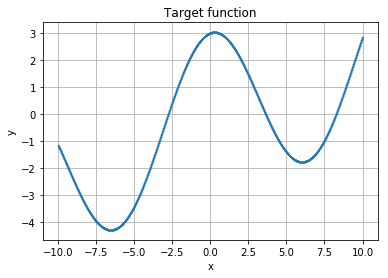

In [3]:
X_grid = np.linspace(-10,10,10000,endpoint=True)
y_noiseless = 3*np.cos(0.5*X_grid)+0.2*X_grid
fig, ax = plt.subplots()
ax.plot(X_grid, y_noiseless,".",markersize=0.45)

ax.set(xlabel='x', ylabel='y',
       title='Target function')
ax.grid()

In [4]:
# generate X points and noise(from uniform distribution)
np.random.seed(42)
X = np.random.random_sample(10000)*20-10
noise = np.random.random_sample(10000)

In [5]:
# chek are the boundry conditions satisfied
sum(noise == 1) + sum(noise == 0)

0

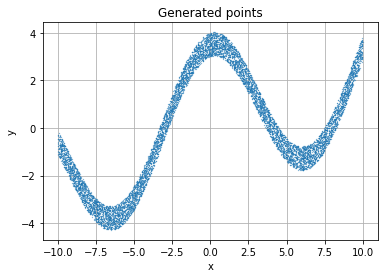

In [6]:
# generate y points (with added noise)
y = 3*np.cos(0.5*X)+0.2*X+noise
fig, ax = plt.subplots()
ax.plot(X, y,".",markersize=0.45)

ax.set(xlabel='x', ylabel='y',
       title='Generated points')
ax.grid()

Split the data 

In [7]:
 X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0],1), y.reshape(y.shape[0],1), 
                                                               test_size=0.20, random_state=80)
    
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, 
                                                               test_size=0.20, random_state=26)

# Model

In [8]:
def create_model(layers,activations, reg):
    """
    MLP with: number of hidden layers = len(layers)-1
    layers is a list specifying the number of units at each layer
    activations is a list specifying the activation at each layer
    reg is the regularization, it can be int or float
    """
    model = Sequential()
    model.add(Dense(layers[0], input_dim=1, activation=activations[0],kernel_regularizer=regularizers.l2(reg)))
    for idx in range(1,len(layers)):
        model.add(Dense(layers[idx], activation=activations[idx],kernel_regularizer=regularizers.l2(reg)))
    return model

In [9]:
def plot_loss(ax, train_score,dev_score,metric):
    """
    Plot the loss at each epoch
    """
    rng = list(range(1, len(train_score)+1))
    ax.plot(rng, train_score, 'b', label='Train')
    ax.plot(rng,dev_score , 'r', label='Dev')
    ax.legend()
  
  
    ax.set_xlabel('Epoch', fontsize=24)
    ax.set_ylabel(metric.upper(), fontsize=24)  

def plot_functions(ax, pred):
    """
    Plot the modeled function vs the true function
    """
    ax.plot(X_grid, y_noiseless,'b',label="True function")
    ax.plot(X_grid, pred, 'r',label='Model function')
    ax.legend()  
    ax.set_xlabel('X', fontsize=24)
    ax.set_ylabel("Y", fontsize=24)  

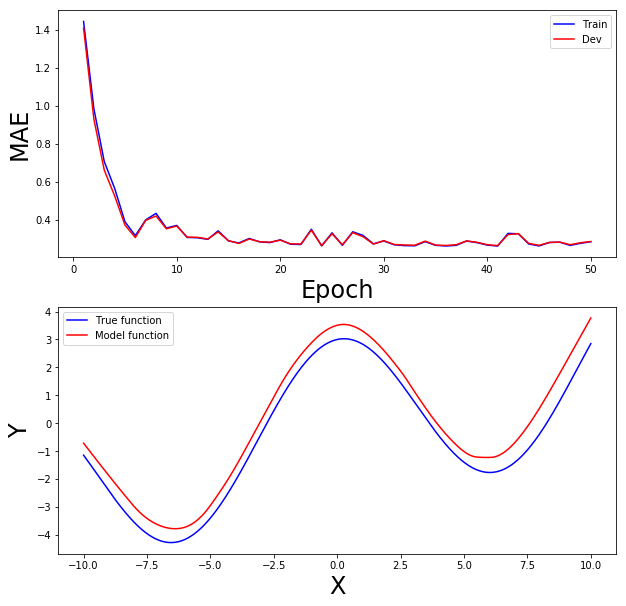

In [12]:
# Create MLP, train it and plot loss(epoch) and true function vs approximated function
layers = [10,10,10,10,1]
activations = ["elu","elu","elu","elu","linear"]
metric = 'mae'
model = create_model(layers,activations, 0.0001)
model.compile(loss=metric, optimizer='sgd')

train_sc = []
dev_sc = []
epochs = 50

for ep in range(epochs):
    model.fit(X_train, y_train, epochs=1, batch_size=32, shuffle=True,verbose=0)
    
    dev_score = model.evaluate(X_dev, y_dev, verbose=0)
    train_score = model.evaluate(X_train, y_train, verbose=0)
    
    dev_sc.append(dev_score)
    train_sc.append(train_score)
    
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
plot_loss(ax1, train_sc, dev_sc, metric)
plot_functions(ax2, model.predict(X_grid, batch_size=32, verbose=0))

In [13]:
print("Test loss:",model.evaluate(X_test, y_test, verbose=0))

Test loss: 0.2849809546470642


# Inverted function 

The inverted function is ambiguas(there isn't unique mapping from y to x).
So the function modeled by multiple  unambiguas functions.
To find the regions in which each function operates. The following was done:
1. Find the extremums of y from the regions in which dy/dx = 0
2. Split the data according to this regions
3. Create N_extremums + 1 models (1 model per region)

Number of points 2000


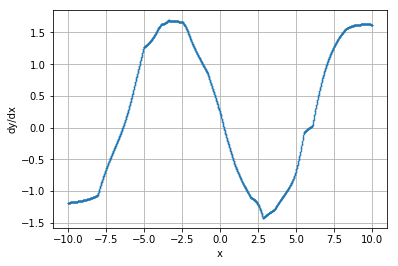

In [14]:
def interpolate_derivitive(step, model):
    """
    Calculates dy/dx from the approximated function
    returns the coordinates of the extremums of y(x)
    """
    bins = np.arange(-10,10,step) # generate evenly spaced points 
    deltas=np.zeros(bins.shape) # this array will store x(i+1)-x(i)
    print("Number of points", bins.shape[0])
    preds = model.predict(bins, batch_size=32, verbose=0) # calculate f(x)
    preds_padded = np.vstack([preds, np.array([0])])
    preds_shifted = np.vstack([np.array([0]), preds])
    deltas = (preds_padded - preds_shifted)/step # claculate (f(x(i+1))-f(x(i)))/delta x
    derivative_points = bins + step/2 # points to which the derivatives correspond
    derivative_points = derivative_points[:-1]
    
    
    deltas = deltas[1:-1]
    # find points within 0 +- epsilon 
    epsilon = 0.02
    mask = np.logical_and(deltas<epsilon, deltas>-epsilon)

    points = derivative_points.reshape(mask.shape)[mask]
    
    x_extremum = []
    summ = points[0]
    prew_point = points[0]
    i = 1
    # Calculate the x_mean of nearby points with close to zero derivate 
    for point in points[1:]:
        if point > (prew_point+10*step):
            x_extremum.append(summ/i)
            summ = point
            i = 1
        else:
            summ += point
            i += 1
        prew_point = point
        
    x_extremum.append(summ/i)
    x_extremum = np.array(x_extremum)
    # find the corresponding y to dy/dx ≈ 0
    y_extremum = model.predict(x_extremum, verbose=0)
            
    fig, ax = plt.subplots()
    ax.plot(derivative_points, deltas,".",markersize=1)

    ax.set(xlabel='x', ylabel='dy/dx')
    ax.grid()
    return x_extremum.reshape(y_extremum.shape),y_extremum
x_extremum,y_extremum = interpolate_derivitive(0.01, model)

In [15]:
def split_data_on_extremums(X_arr,y_arr,x_extr):
    """
    Split the data based on x coordinates of the extremums
    """
    X_new = []
    y_new = []
    X_new.append(X_arr[X_arr<x_extr[0]])
    y_new.append(y_arr[X_arr<x_extr[0]])
    for idx in range(x_extr.shape[0]-1): 
        mask = np.logical_and(X_arr>x_extr[idx],X_arr<x_extr[idx+1])
        X_new.append(X_arr[mask])  
        y_new.append(y_arr[mask])
    X_new.append(X_arr[X_arr>x_extr[-1]])
    y_new.append(y_arr[X_arr>x_extr[-1]])
    return X_new, y_new
X_train_new, y_train_new = split_data_on_extremums(X_train,y_train,x_extremum)
X_dev_new, y_dev_new = split_data_on_extremums(X_dev,y_dev,x_extremum)
X_test_new, y_test_new = split_data_on_extremums(X_test,y_test,x_extremum)
X_grid_new, y_grid_new = split_data_on_extremums(X_grid,y_noiseless,x_extremum)
print("Dev",[arr.shape[0] for arr in X_dev_new])
print("Test",[arr.shape[0] for arr in X_test_new])
print("Train",[arr.shape[0] for arr in X_train_new])
print("Grid",[arr.shape[0] for arr in X_grid_new])

Dev [302, 556, 459, 283]
Test [361, 660, 579, 400]
Train [1179, 2165, 1729, 1327]
Grid [1805, 3320, 2822, 2053]


In [16]:
def ideal_prediction(models):
    """
    Predict x from  y(x on a grid without noise)
    """
    preds = np.zeros((y_noiseless.shape[0],1))
    start_idx = 0
    end_idx = 0
    for idx in range(len(models)):
        predictions = models[idx].predict(y_grid_new[idx],batch_size=32, verbose=0)
        end_idx += predictions.shape[0]
        preds[start_idx:end_idx] = predictions
        start_idx = end_idx
    return preds
def plot_inverted_function(ax, pred):
    """
    Plot the true function and the model function
    """
    ax.plot(y_noiseless,X_grid,'b',label="True inverted function")
    ax.plot(y_noiseless, pred, 'r',label='Model inverted function')
    ax.legend()  
    ax.set_xlabel('Y', fontsize=24)
    ax.set_ylabel("X", fontsize=24)  

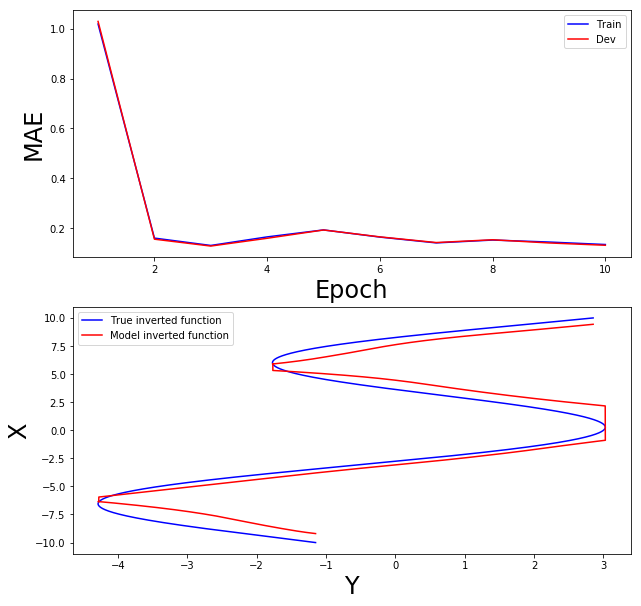

In [17]:
# Create 4 MLPs(one per region), train it and plot loss(epoch) and true function vs approximated function

layers = [10,10,10,1]
activations = ["elu","elu","elu","linear"]
metric = 'mae'
regular_param = 0.01
model_1 = create_model(layers,activations, regular_param)
model_1.compile(loss=metric, optimizer='sgd')

model_2 = create_model(layers,activations, regular_param)
model_2.compile(loss=metric, optimizer='sgd')

model_3 = create_model(layers,activations, regular_param)
model_3.compile(loss=metric, optimizer='sgd')

model_4 = create_model(layers,activations, regular_param)
model_4.compile(loss=metric, optimizer='sgd')

models = [model_1,model_2,model_3,model_4]
train_sc = []
dev_sc = []
epochs = 10

for ep in range(epochs):
    dev_score = 0
    train_score = 0
    for idx in range(len(models)):
        models[idx].fit(y_train_new[idx],X_train_new[idx], epochs=1, batch_size=32, shuffle=True,verbose=0)
        dev_score =+ models[idx].evaluate(y_dev_new[idx],X_dev_new[idx], verbose=0)
        train_score =+ models[idx].evaluate(y_train_new[idx],X_train_new[idx], verbose=0)

    dev_sc.append(dev_score/4)
    train_sc.append(train_score/4)
preds = ideal_prediction(models)    
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
plot_loss(ax1, train_sc,dev_sc, metric)
plot_inverted_function(ax2, preds)

In [18]:
test_score = 0
for idx in range(len(models)):
    test_score =+ models[idx].evaluate(y_test_new[idx],X_test_new[idx], verbose=0)
print("Test score",test_score/4)

Test score 0.13437409698963165


Final Sanity chek

In [19]:
def final_prediction(y_cord):
    """
    Make prediction with each model for its own region
    """
    preds = []
    if y_cord > max(y_train) or y_cord < min(y_train):
        print("y out of range")
        return
    model_1_range = (min(y_train_new[0]),max(y_train_new[0]))
    model_2_range = (min(y_train_new[1]),max(y_train_new[1]))
    model_3_range = (min(y_train_new[2]),max(y_train_new[2]))
    model_4_range = (min(y_train_new[3]),max(y_train_new[3]))
    if y_cord >= model_1_range[0] and y_cord <= model_1_range[1]:
        pred =  models[0].predict(np.array(y_cord).reshape(1,1),verbose=0)
        print("Model 1 prediction:",pred)
        preds.append(pred)
    if y_cord >= model_2_range[0] and y_cord <= model_2_range[1]:
        pred =  models[1].predict(np.array(y_cord).reshape(1,1),verbose=0)
        print("Model 2 prediction:",pred)
        preds.append(pred)
    if y_cord >= model_3_range[0] and y_cord <= model_3_range[1]:
        pred =  models[2].predict(np.array(y_cord).reshape(1,1),verbose=0)
        print("Model 2 prediction:",pred)
        preds.append(pred)
    if y_cord >= model_4_range[0] and y_cord <= model_4_range[1]:
        pred =  models[3].predict(np.array(y_cord).reshape(1,1),verbose=0)
        print("Model 3 prediction:",pred)
        preds.append(pred)
    return preds
    
print("Enter y between",min(y_train),max(y_train))   
val = 0
preds = final_prediction(val)  
y_es = []
for pred in preds:
    y_s = model.predict(np.array(pred),verbose=0)
    y_es.append(y_s)
print(y_es)

Enter y between [-4.25275045] [4.02372088]
Model 2 prediction: [[-3.0836241]]
Model 2 prediction: [[4.4576344]]
Model 3 prediction: [[7.6192136]]
[array([[-0.03810512]], dtype=float32), array([[-0.5655741]], dtype=float32), array([[0.03312771]], dtype=float32)]
